In [13]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용되는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [4]:
# CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# fashion_mnist 데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST("/content/drive/MyDrive/Colab Notebooks/EURON/Week3/data",download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("/content/drive/MyDrive/Colab Notebooks/EURON/Week3/data",download=True,
                                                  train = False, transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:11<00:00, 2214539.20it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/EURON/Week3/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/EURON/Week3/data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203402.25it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/EURON/Week3/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/EURON/Week3/data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3775585.67it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/EURON/Week3/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/EURON/Week3/data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5415670.18it/s]

Extracting /content/drive/MyDrive/Colab Notebooks/EURON/Week3/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/EURON/Week3/data/FashionMNIST/raw



In [10]:
# fashion_mnist 데이터를 데이터로더에 전달

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=100)

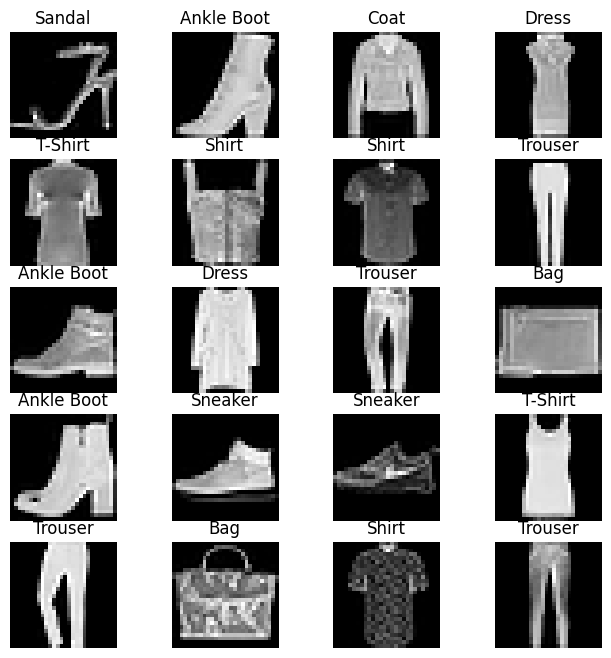

In [12]:
# 분류에 사용된 클래스 정의

labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
columns = 4;
rows = 5;

for i in range(1,columns*rows+1):
  img_xy = np.random.randint(len(train_dataset))
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')

plt.show()

In [14]:
# 심층 신경망 모델 생성

class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784,out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256,out_features=128)
    self.fc3 = nn.Linear(in_features=128,out_features=10)

  def forward(self, input_data):
    out = input_data.view(-1,784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

In [15]:
# 심층 신경망에서 필요한 파라미터 정의

learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [16]:
# 심층 신경망을 이용한 모델 학습

num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100,1,28,28))
    labels = Variable(labels)

    outputs = model(train) # 학습 데이터를 모델에 적용
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images,labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100,1,28,28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count,loss.data,accuracy))

Iteration: 500, Loss: 0.5920858979225159, Accuracy: 83.04999542236328%
Iteration: 1000, Loss: 0.4478071630001068, Accuracy: 84.2699966430664%
Iteration: 1500, Loss: 0.41073477268218994, Accuracy: 84.0999984741211%
Iteration: 2000, Loss: 0.44612133502960205, Accuracy: 85.27999877929688%
Iteration: 2500, Loss: 0.24866513907909393, Accuracy: 86.19999694824219%
Iteration: 3000, Loss: 0.287078320980072, Accuracy: 86.6500015258789%


In [23]:
# 합성곱 네트워크 생성

class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN,self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10) # 마지막 계층의 out_features는 클래스 개수를 의미

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0),-1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [24]:
# 합성곱 네트워크를 위한 파라미터 정의

learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [25]:
# 모델 학습 및 성능 평가

num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100,1,28,28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images,labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100,1,28,28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count,loss.data,accuracy))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4062001705169678, Accuracy: 87.80999755859375%
Iteration: 1000, Loss: 0.3727802336215973, Accuracy: 86.11000061035156%
Iteration: 1500, Loss: 0.2803680896759033, Accuracy: 88.3699951171875%
Iteration: 2000, Loss: 0.20692548155784607, Accuracy: 89.57999420166016%
Iteration: 2500, Loss: 0.1934647560119629, Accuracy: 89.40999603271484%
Iteration: 3000, Loss: 0.19841471314430237, Accuracy: 90.41999816894531%
